# SUPERMARKET SALES

Proyecto de análisis de Series Temporales y Forecast
-- EDA --

Jose Luis Quintero García, abr2023

### Importación de librerías y carga de datos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
ordenes = pd.read_csv("./ordenes.csv", parse_dates=["Order Date", "Ship Date"])
ordenes.head()

,Order ID,Order Date,Ship Date,Ship Mode,Sales,Quantity,Discount,Profit,Devolucion
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,261.9600,2,0.00,41.9136,0
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,731.9400,3,0.00,219.5820,0
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,14.6200,2,0.00,6.8714,0
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,957.5775,5,0.45,-383.0310,0
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,22.3680,2,0.20,2.5164,0


In [8]:
ordenes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order ID    9994 non-null   object        
 1   Order Date  9994 non-null   datetime64[ns]
 2   Ship Date   9994 non-null   datetime64[ns]
 3   Ship Mode   9994 non-null   object        
 4   Sales       9994 non-null   float64       
 5   Quantity    9994 non-null   int64         
 6   Discount    9994 non-null   float64       
 7   Profit      9994 non-null   float64       
 8   Devolucion  9994 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(2)
memory usage: 702.8+ KB


Hay que tener en cuenta que aquí se almacenan pedidos que pueden tener varias líneas y, por tanto, el Order ID no es único. Y podría haber varios pedidos en un solo día, incluso en la misma ciudad, por lo que la fecha tampoco es única.

Por tanto, ahora mismo tenemos varias series temporales. Querremos analizar las ventas de los supermercados, pero los pasos siguientes dependera´n de las preguntas que nos hagamos. Supongamos la siguiente lista:

- ¿Cual es la evolución de ventas totales global de la empresa con el tiempo?
- ¿Y su rentabilidad?
- ¿Y por ciudades?¿Qué ciudad vende más?
- ¿Qué producto es el que más se vende en el total de la empresa?
- Idem por ciudades
- ¿Qeé producto es el más rentable?¿Coincide con el que más factura?
- ¿Y qué ciudad?¿Coincide con la que más factura?

Después elegiremos el producto más rentable y la ciudad más rentable y veremos su evolución temporal para el siguiente paso.



## Análisis de toda la empresa

Para esto agruparemos todas las ventas por fecha, sumando valores numéricos. Aquí no nos importan los datos categóricos. Usaremos la fecha de pedido (Order Date) y hay que tener en cuenta que los pedidos devueltos no deben sumar.

Además, los datos diarios para una serie de tanto tiempo posiblemente sea una frecuencia excesiva. Agruparemos los datos por ventas mensuales.

In [38]:
ordenes_totales = ordenes.groupby(ordenes["Order Date"]).sum()
ordenes_totales.head()

C:\Users\Jose Luis\AppData\Local\Temp\ipykernel_7360\755962988.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ordenes_totales = ordenes.groupby(ordenes["Order Date"]).sum()


,Sales,Quantity,Discount,Profit,Devolucion
Order Date,,,,,
2014-01-03,16.448,2,0.2,5.5512,0
2014-01-04,288.060,8,1.2,-65.9901,0
2014-01-05,19.536,3,0.2,4.8840,0
2014-01-06,4407.100,30,0.0,1358.0524,0
2014-01-07,87.158,10,1.4,-71.9621,0


In [29]:
# Quitamos los registros donde haya una devolución
ordenes_totales = ordenes_totales.loc[ordenes_totales["Devolucion"]==0]

# Borramos la columna "devolucion", que ahora sobra
ordenes_totales.drop(["Devolucion"], axis=1, inplace=True)

ordenes_totales.head()

,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-03,16.448,2,0.2,5.5512
2014-01-04,288.060,8,1.2,-65.9901
2014-01-05,19.536,3,0.2,4.8840
2014-01-06,4407.100,30,0.0,1358.0524
2014-01-07,87.158,10,1.4,-71.9621


In [44]:
# Cambiamos la frecuencia a datos mensuales
ordenes_mensuales = ordenes_totales.resample("MS").ffill()
ordenes_mensuales = ordenes_mensuales.fillna(0)
ordenes_mensuales.head()

,Sales,Quantity,Discount,Profit,Devolucion
Order Date,,,,,
2014-01-01,0.000,0.0,0.0,0.0000,0.0
2014-02-01,468.900,6.0,0.0,206.3160,0.0
2014-03-01,2203.151,40.0,2.5,-208.9614,0.0
2014-04-01,119.888,12.0,0.2,26.0896,0.0
2014-05-01,1048.740,13.0,0.0,276.4956,0.0


<Axes: xlabel='Order Date'>

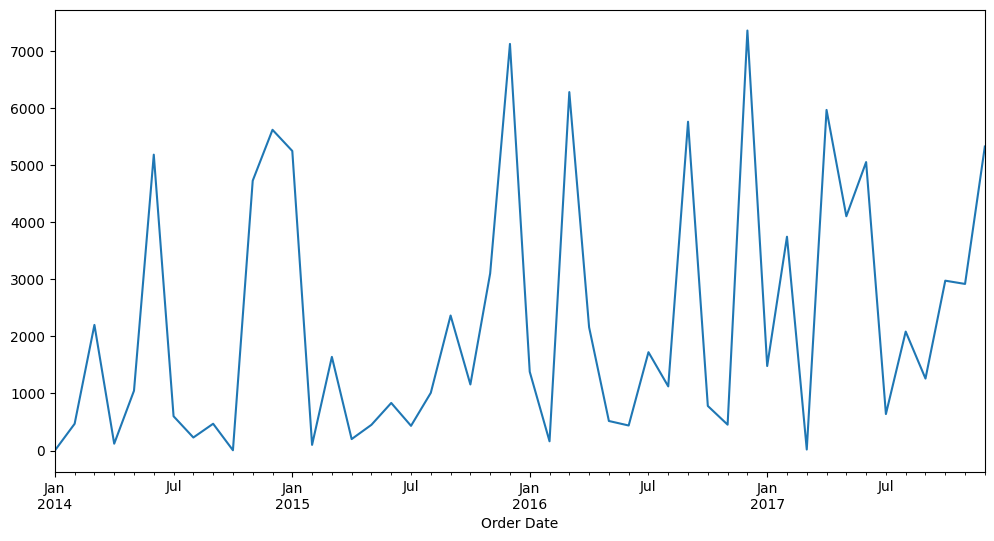

In [45]:
ordenes_mensuales["Sales"].plot(figsize=[12,6])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 978 entries, 2014-01-03 to 2017-12-27
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     978 non-null    float64
 1   Quantity  978 non-null    int64  
 2   Discount  978 non-null    float64
 3   Profit    978 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 38.2 KB
